In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'graph_fine_tuning'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

In [3]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)
metrics_df = metrics_df.reset_index(drop=True)
confusion_matrix_df = confusion_matrix_df.reset_index(drop=True)
synthethetic_df = synthethetic_df.reset_index(drop=True)
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set', 'shuffle_feature', 'strategy']))

print(labels)

['lr', 'batch_size', 'hidden_size']


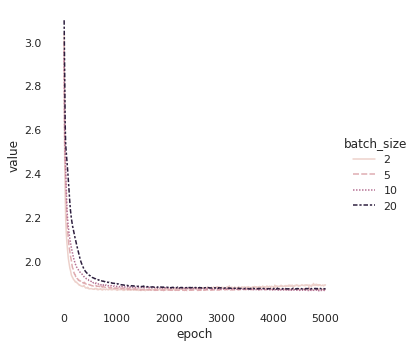

In [4]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
    'batch_size': 5,
    'hidden_size': 5,
    'lr': "1.e-3",
    'set': 'test'
}

focus = ['batch_size','batch_size']

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

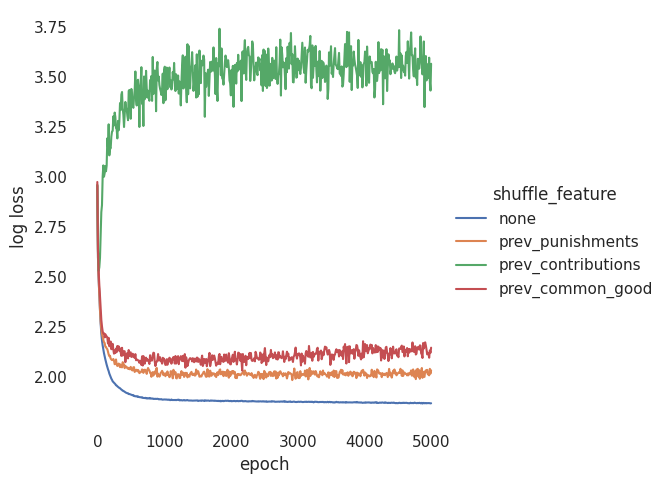

In [5]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
    'batch_size': 10,
    'hidden_size': 5,
    'lr': "1.e-3",
    'set': 'test'
}

focus = ['shuffle_feature']

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.set(ylabel='log loss')

fg.savefig(os.path.join(plot_folder, 'feature_importance.jpg'))

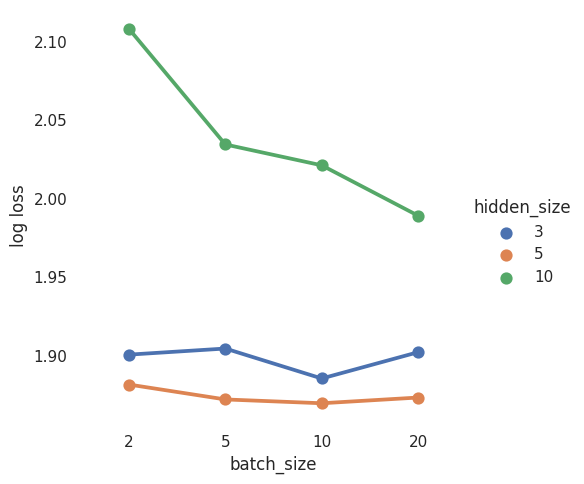

In [6]:
metric_name = 'log_loss'

df = metrics_df.copy()

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
    'batch_size': 5,
    'hidden_size': 5,
    'lr': "1.e-3",
    'set': 'test',
    'epoch': 4000
}

focus = ['batch_size','hidden_size']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


fg = sns.catplot(
    data=df[w], 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='point', ci=None)
fg.set(ylabel='log loss')

fg.savefig(os.path.join(plot_folder, 'hidden_batch.jpg'))

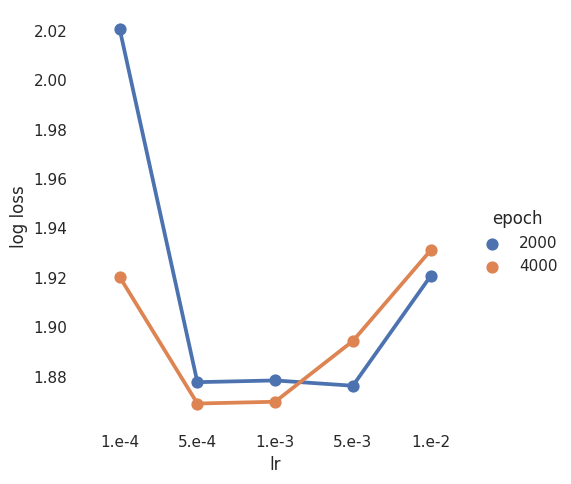

In [7]:
metric_name = 'log_loss'

df = metrics_df.copy()

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
    'batch_size': 10,
    'hidden_size': 5,
    'lr': "1.e-3",
    'set': 'test',
    'epoch': [2000, 4000]
}

focus = ['lr', 'epoch']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


fg = sns.catplot(
    data=df[w], 
    y='value',
    x=focus[0] if len(focus) >= 1 else None,
    order=['1.e-4', '5.e-4', '1.e-3', '5.e-3', '1.e-2'],
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='point', ci=None)
fg.set(ylabel='log loss')

fg.savefig(os.path.join(plot_folder, 'lr.jpg'))

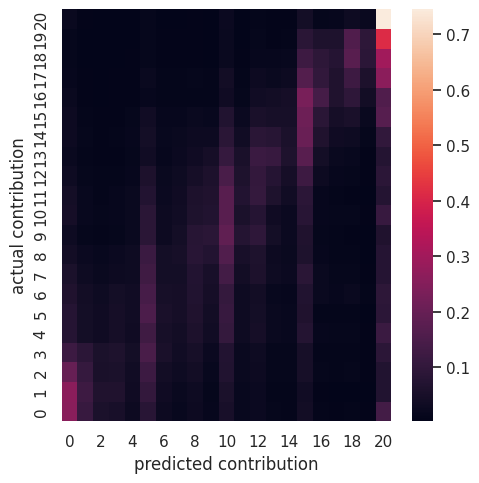

In [8]:
df = confusion_matrix_df.copy()
df['episode quartile'] = (df['round_number'] // 4) + 1

selection = {
    'batch_size': 5,
    'hidden_size': 5,
    'lr': "1.e-3",
    'valid': True,
    # 'round_number': [1,8,15]
}

focus_dimensions = []#, 'hidden_size', 'weight_decay']

try:
    w = pd.concat(
        (df[k].isin(v) if isinstance(v, list) else df[k] == v
        for k,v in selection.items()
        if (k not in focus_dimensions) or isinstance(v, list)), axis=1
    ).all(1)

    df = df[w]
except:
    pass


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='true_contribution',y='pred_contribution', values='proba', normalise=True)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

fg.set(xlabel='predicted contribution', ylabel='actual contribution')

fg.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'))

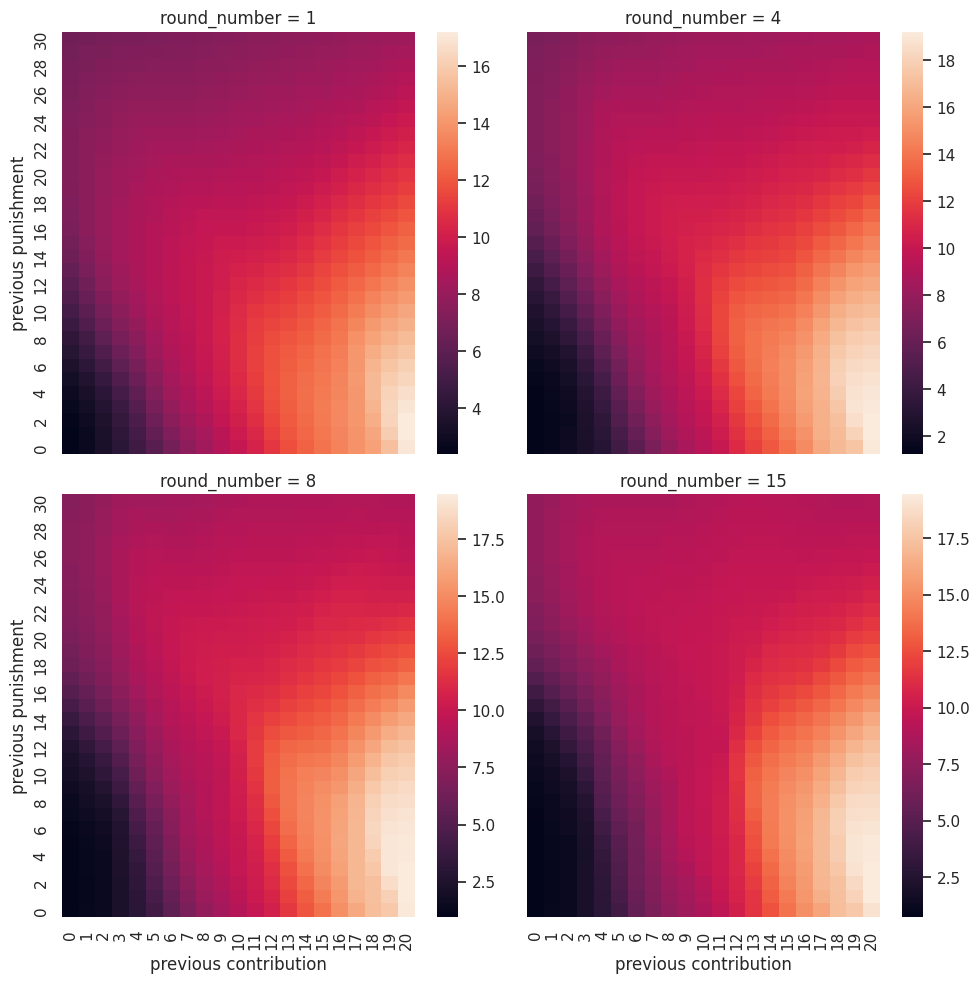

In [9]:
df = synthethetic_df.copy()

selection = {
    'batch_size': 10,
    'hidden_size': 5,
    'lr': "1.e-3",
    'round_number': [1,4,8,15]
}

focus_dimensions = ['round_number']#, 'hidden_size', 'weight_decay']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus_dimensions) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

df = df.groupby(focus_dimensions + ['prev_contributions', 'prev_punishments'])['exp_contribution'].mean().reset_index(drop=False)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_punishments',y='prev_contributions', values='exp_contribution', normalise=False)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    col_wrap=2 if len(focus_dimensions) < 2 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

fg.set(xlabel='previous contribution', ylabel='previous punishment')

fg.savefig(os.path.join(plot_folder, 'expected_contribution.jpg'))

/tmp/ipykernel_20363/4065475158.py:31: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([dfc, df]).reset_index()


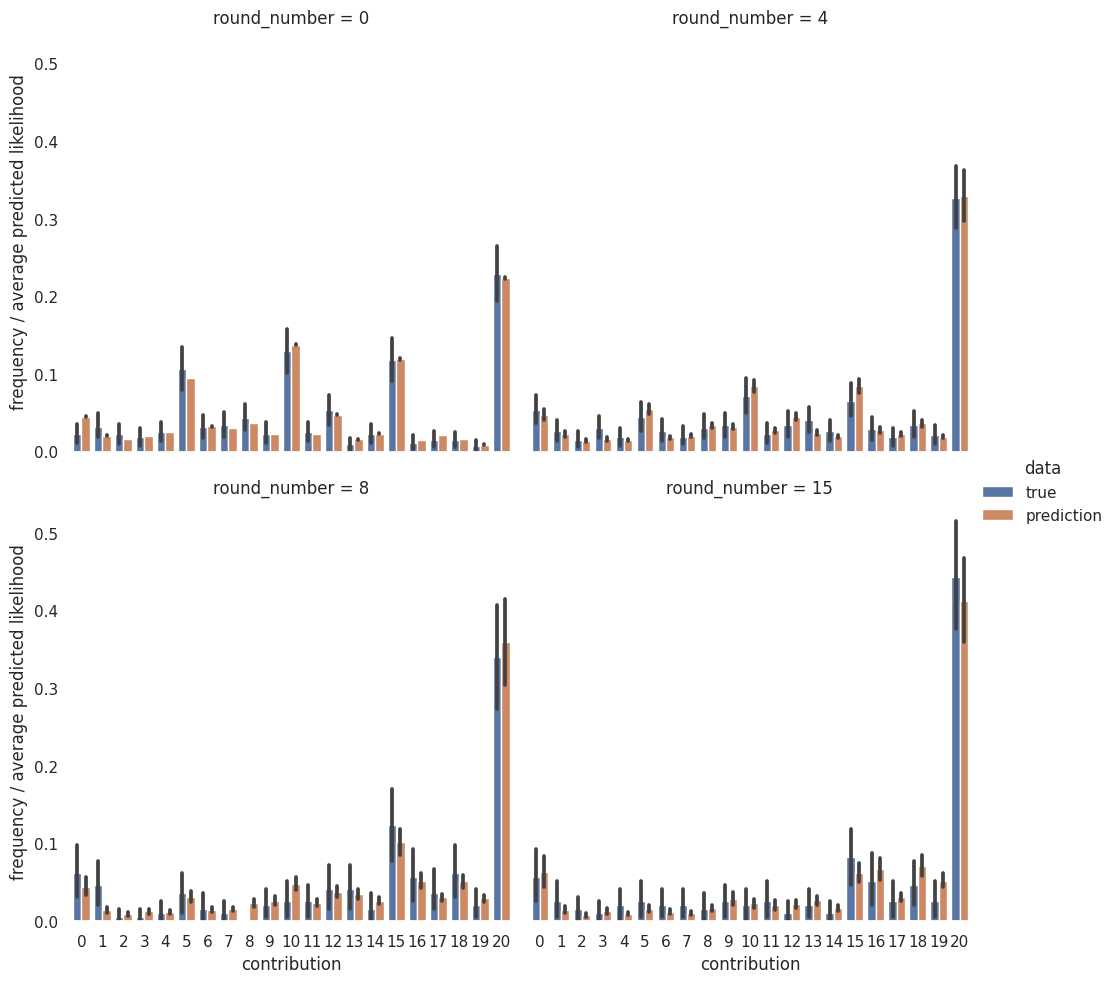

In [10]:
df = confusion_matrix_df.copy()


selection = {
    'batch_size': 5,
    'hidden_size': 3,
    'lr': "1.e-3",
    'round_number': [0,4,8,15],
    'valid': True
}

focus_dimensions = ['data', 'round_number']#, 'hidden_size', 'weight_decay']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus_dimensions) or isinstance(v, list)), axis=1
).all(1)

df = df[w]


dfc = df.copy()

df['data'] = 'prediction'

dfc['proba'] = df['pred_contribution'] == df['true_contribution']

dfc['data'] = 'true'

df = pd.concat([dfc, df]).reset_index()

fg = sns.catplot(
    data=df, x='pred_contribution', y='proba',
    hue=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    col=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    row=focus_dimensions[2] if len(focus_dimensions) > 2 else None,
    col_wrap=2 if len(focus_dimensions) <= 2 else None,
    height=5, kind='bar')
fg.set(xlabel='contribution', ylabel='frequency / average predicted likelihood')

fg.savefig(os.path.join(plot_folder, 'distribution.jpg'))

In [11]:
synthethetic_df.head()

,batch_size,hidden_size,lr,cv_split,epoch,idx,round_number,prev_punishments,prev_contributions,exp_contribution
0,5,10,1.e-4,0,4999,0,0,15,10,11.789782
1,5,10,1.e-4,0,4999,0,1,0,0,1.785738
2,5,10,1.e-4,0,4999,0,2,0,0,1.600035
3,5,10,1.e-4,0,4999,0,3,0,0,1.519511
4,5,10,1.e-4,0,4999,0,4,0,0,1.476993


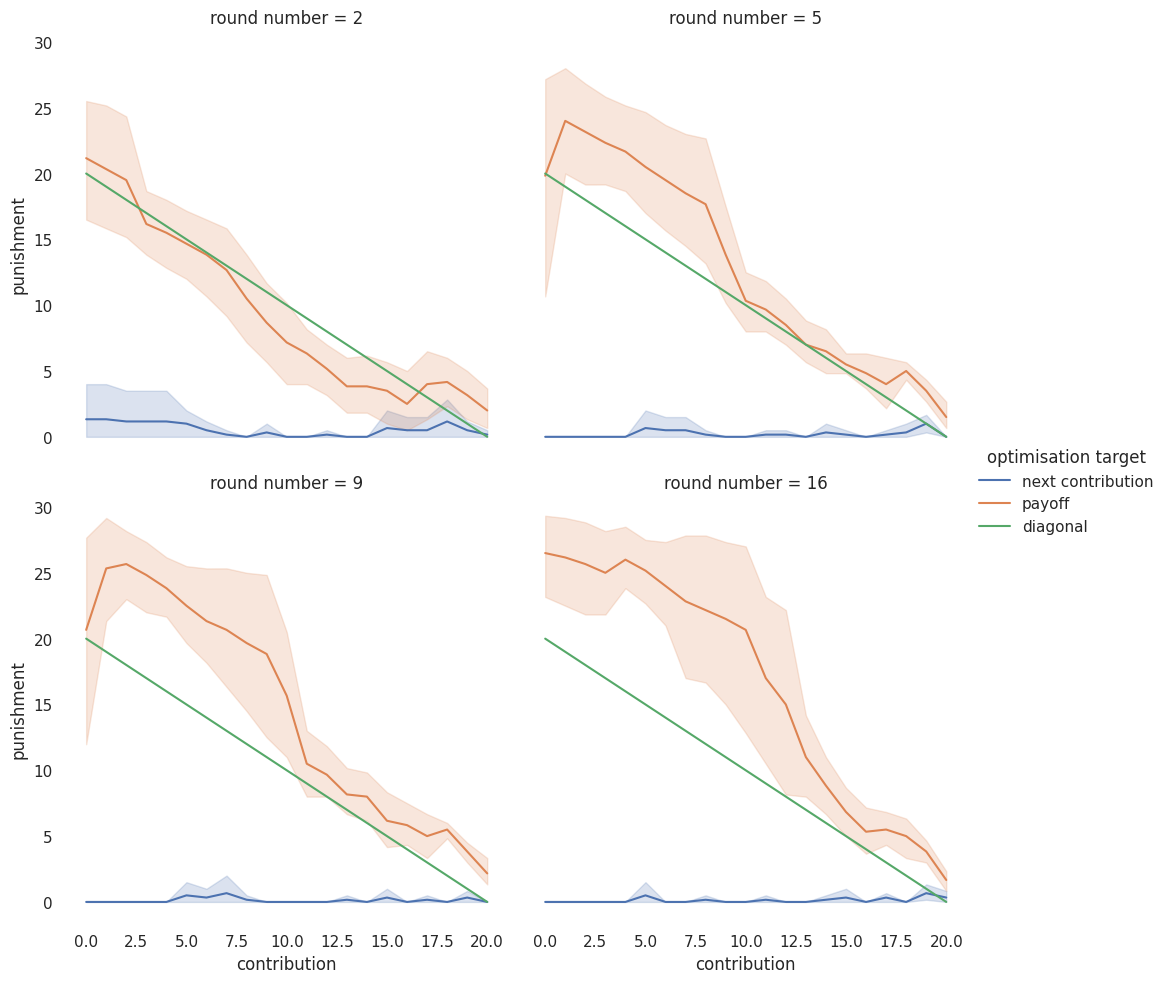

In [19]:
df = synthethetic_df.copy()

selection = {
    'batch_size': 10,
    'hidden_size': 5,
    'lr': "1.e-3",
    'round_number': [1,4,8,15]
}

focus_dimensions = ['optimisation target','round number']#, 'hidden_size', 'weight_decay']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus_dimensions) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

df1 = df
df2 = df.copy()
df1['optimisation target'] = 'next contribution'
df2['optimisation target'] = 'payoff'


df1['value'] = df1['exp_contribution'] * 1.6 - df1['prev_punishments']
df2['value'] = df2['exp_contribution']
df = pd.concat([df1, df2])

# we shift the naming from previous to current and have to adjust the round number correspondingly
df['round number'] = df['round_number'] + 1



df = df.groupby(focus_dimensions + ['prev_contributions', 'prev_punishments', 'cv_split'])['value'].mean()

df_max = df.groupby(focus_dimensions + ['prev_contributions', 'cv_split']).transform('max') == df

df_max.name = 'optimal punishment'
df_max = df_max.reset_index()

df_max = df_max[df_max['optimal punishment']]

# hacky way to add diagonal to plot
df_line = df_max.groupby(focus_dimensions[1:] + ['prev_contributions']).first()
df_line = df_line.reset_index()
df_line['optimisation target'] = 'diagonal'
df_line['prev_punishments'] = 20 - df_line['prev_contributions']

df = pd.concat([df_max, df_line]).reset_index(drop=True)

fg = sns.relplot(
    data=df, x='prev_contributions', y='prev_punishments',
    hue=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    col=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    row=focus_dimensions[2] if len(focus_dimensions) > 2 else None,
    col_wrap=2 if len(focus_dimensions) <= 2 else None,
    height=5, kind='line')
fg.set(xlabel='contribution', ylabel='punishment')



fg.savefig(os.path.join(plot_folder, 'myopic_optimal.jpg'))